#  Algoritmo de Metropolis-Hastings con Implementación de Varios walkers.
#### En el presente trabajo se implementa el algoritmo de Metropolis-Hastings en el cual por default y como una forma de comprobar los resultados se adapta para el caso de un modelo lineal de un conjunto de datos.

# *(ACTIVIDAD DE CLASE 02/nov/2020)*
## *Tomar los datos del archivo tets_line.npy y resolver mediante el código desarrollado por el alumno y usando la librería emcee*

#### Se importan las librerías a utilizar.

In [232]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random
from scipy.optimize import curve_fit

#### En especial se importan dos distribuciones que serán de utilidad en el algoritmo. Estas son las distribuciones de probabilidad consideradas para calcular el PRIOR de cada parámetro.

In [233]:
from scipy.stats import distributions
dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf

#### Se cargan los datos que se analizarán.

In [234]:
data=np.load('test_line.npy')
xd=data[0]
yd=data[1]
yderror=data[2]

<Figure size 432x288 with 0 Axes>

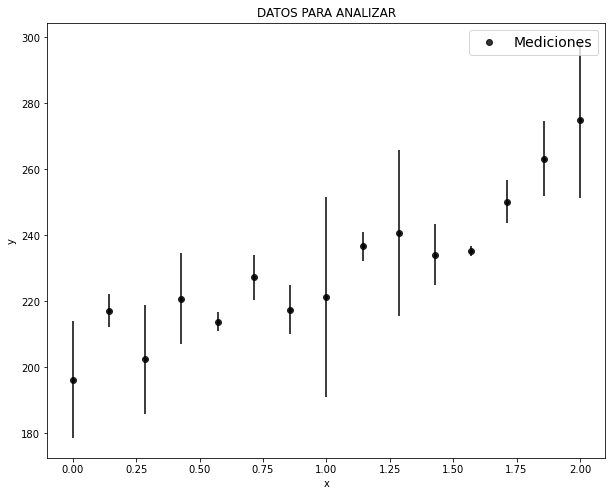

In [235]:
plt.figure()
plt.figure(figsize=(10,8))
plt.errorbar(xd, yd, yerr=yderror, fmt=".k", capsize=0)
plt.plot(xd,yd,'ko', alpha=0.8, lw=2, label="Mediciones")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y")
plt.title("DATOS PARA ANALIZAR")
plt.show()

#### Se define una función que permita el cálculo del POSTERIOR $\ln\left(P\left(\theta\left|D\right.\right)\right)$, es decir $\ln\left(P\left(\theta\left|D\right.\right)\right)\propto\ln\left(L\left(D\left|\theta\right.\right)\right)+\ln\left(P(\theta)\right)$
#### Esta función depende del conjunto de parámetros $\theta$ según el modelo y los datos. En el caso de un modelo lineal este conjunto de parámetros son $a$, $b$. Se calcula el $\ln\left(P\left(\theta\left|D\right.\right)\right)$ como la contribución de: 
#### 1. Suma del logaritmo de la probabilidad de $a$ y $b$ según la distribución normal con media igual a cero y una desviación estándar.
#### 2. Sumando el likelihood que en este caso se asume que es gaussiano, donde $y$ y $x$ son los datos observados y $\mu$ es el modelo que se pretende construir dados los parámetros. 
#### *Recordar que se trabaja con logaritmos de las probabilidades, pues es mejora la convergencia del método.

### Función Posterior

In [236]:
def posterior(a, b, y=yd, x=xd, yerror=yderror):
    #Priors de a + b
    logposterior =0   #Tomando un prior constante   #dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    #Media=Modelo
    mu = a + b*x
    #Likelihood
    logposterior += -0.5*np.sum(np.log(2*np.pi*yerror**2)+(y - mu)**2/(yerror**2)) 
    
    return logposterior

### Algoritmo de Metropolis-Hastings

In [237]:
def metropolis(iteraciones, valores_iniciales, var_prop):
    n_param = len(valores_iniciales) 
    #Desviaciones estándar iniciales propuestas 
    sd_prop = [var_prop]*n_param #crea un vector con valores iguales a var_prop (Desviación estándar propuesta) 
                                 #con elementos iguales al número de parámetros.
    #Almacenamiento de parámetros calculados.
    Reserv_param = np.empty((iteraciones+1, n_param)) #crea un arreglo vacío con n_param columnas y iteraciones+1 filas dado que en la 
    #fila uno van los valores guess.
    Reserv_param_re = np.zeros((iteraciones+1, n_param)) 
    #Introduce los valores iniciales de los parámetros.
    Reserv_param[0] = valores_iniciales #Llena la primer fila con los valores guess.
    Reserv_param_re[0] = valores_iniciales 
    #Se calcula el posterior incial (actual) 
    posterior_1 = posterior(*Reserv_param[0]) #Agrega los parámetros (a,b) como vector a la función que calcula el posterior   
    rnorm = np.random.normal
    runif = np.random.rand  
    for i in range(iteraciones):
        valores_param = Reserv_param[i] #Toma la fila i-ésima de valores para los parámetros del almacenamiento.
        for j in range(n_param): #CORRE SOBRE EL NÚMERO DE PARÁMETROS (debido a las dos diferentes funciones de distribución 
                                 #de probabilidad). En el caso del modelo lineal de 1 a 3.
            p = Reserv_param[i].copy() #Realiza una copia de la fila i-esima, p amacenará o no los parámetros nuevos dada la comparación
                                       #Simplemente se pretende tomar la estructura del arreglo.
            #SE GENERAN MUESTRAS ALEATORIAS DE VALORES CENTRADOS EN NUESTROS VALORES ACTUALES DE LOS PARÁMETROS
            alpha = np.random.normal (valores_param[j], sd_prop[j])
            #Se llena el vector p con las muestras calculadas.
            p[j] = alpha #AGREGA VALORES CALCULADOS en la columna j-ésima del vector P  que es copia de la i-ésima fila 
                         #de Reserv_param para calcular el nuevo posterior.
            posterior_2 = posterior(*p) #Calcula el posterior nuevo.
            r = posterior_2 - posterior_1
            va = runif() #Muestra de una variable aleatoria uniforme entre 0-1
            #Comparación
            if np.log(va) < r: #Se acepta
                Reserv_param[i+1,j] = alpha #Almacenamos los valores nuevos de los parámetros.
                posterior_1= posterior_2
            else: #Se rechaza
                Reserv_param[i+1,j] = Reserv_param[i,j] #Almacenamos los valores antiguos de los parámetros.
                Reserv_param_re[i+1,j] = Reserv_param[i,j]
                
    return Reserv_param, Reserv_param_re

# Sea un número de iteraciones, con 4 walkers y varianza igual a $0.05$:

In [321]:
n_param=2 #Número de parámetros
nc=4 #Número de walkers - Número de cadenas
iteraciones=1000000 #Número de iteraciones
CA=random.uniform(-1,1, size=(nc, n_param)) #Matriz que almacena los valores guess para cada walker. Se toman valores aleatorios entre [-valor,valor]
T_cam=np.empty((nc,iteraciones+1,n_param)) #Tensor que acumula la evolución de los walkers 
for l in range(nc):
    Reserv_param, Reserv_param_re = metropolis(iteraciones,CA[l-1],0.05)
    T_cam[l]=Reserv_param


# Presentación de algunos resultados e información en gráficas.

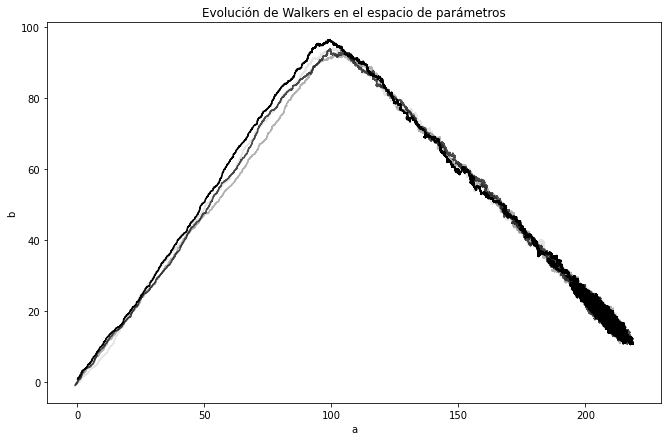

In [322]:
plt.figure(figsize=(11,7))
plt.plot(T_cam[0,:,0],T_cam[0,:,1],"k", alpha=0.1)
plt.plot(T_cam[1,:,0],T_cam[1,:,1],"k", alpha=0.3)
plt.plot(T_cam[2,:,0],T_cam[2,:,1],"k", alpha=0.7)
plt.plot(T_cam[3,:,0],T_cam[3,:,1],"k", alpha=1)
plt.title('Evolución de Walkers en el espacio de parámetros')
plt.xlabel("a")
plt.ylabel("b")
plt.show()

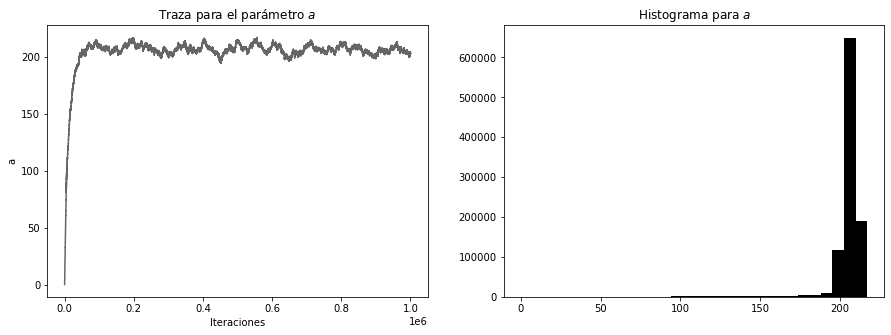

In [323]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.arange(T_cam[0,:,0].shape[0]),T_cam[0,:,0],"k", alpha=0.6)
plt.title('Traza para el parámetro $a$')
plt.xlabel("Iteraciones")
plt.ylabel("a")

plt.subplot(122)
plt.hist(T_cam[0,:,0],color='black',bins=30)
plt.title('Histograma para $a$')

plt.show()

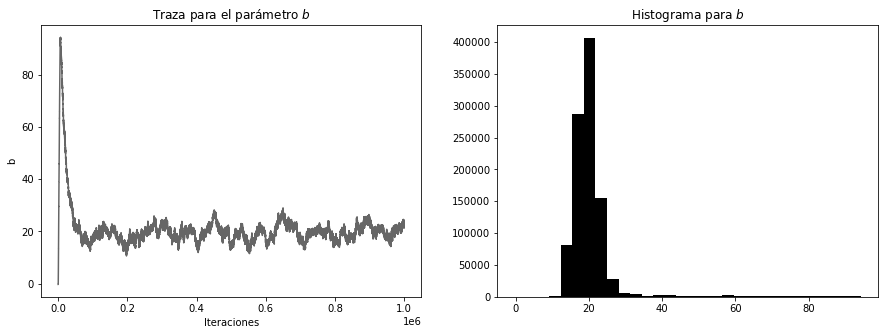

In [324]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.arange(T_cam[0,:,1].shape[0]),T_cam[0,:,1],"k", alpha=0.6)
plt.title('Traza para el parámetro $b$')
plt.xlabel("Iteraciones")
plt.ylabel("b")

plt.subplot(122)
plt.hist(T_cam[0,:,1],color='black',bins=30)
plt.title('Histograma para $b$')

plt.show()

# Diagnostico de Gelman-Rubin.
**Descripción:**

**If our MH MCMC Chain reaches a stationary distribution, and we repeat the excercise multiple times, then we can examine if the posterior for each chain converges to the same place in the distribution of the parameter space.**

Steps:

1. Run M>1 Chains of length 2×N.
2. Discard the first N draws of each chain, leaving N iterations in the chain.
3. Calculate the within and between chain variance.

- Within chain variance: $W=\frac1M\sum_{j=1}^Ms_j^2$ \
where $s_j^2$ is the variance of each chain (after throwing out the first N draws).
- Between chain variance: $B=\frac M{N-1}\sum_{j=1}^M\left({\overline\theta}_j-\overline{\overline\theta}\right)^2$ \
where $\overline{\overline\theta}$ is the mean of each of the M means.
4. Calculate the estimated variance of $\theta$ as the weighted sum of between and within chain variance.

$var\left(\theta\right)=\left(1-\frac1N\right)W+\frac1NB$

5. Calculate the potential scale reduction factor.

$R=\sqrt{\frac{var\left(\theta\right)}W}$

***We want this number to be close to 1. Why? This would indicate that the between chain variance is small. This makes sense, if between chain variance is small, that means both chains are mixing around the stationary distribution.*** 

In [325]:
N=iteraciones 
R=np.zeros((1,n_param)) #Arreglo que almacena the potential scale reduction factor para cada parámetro.
for k in range(n_param): #El ciclo en k recorre sobre los parámetros.
    W_sum=0
    meansum=0
    B=0
    for i in range(nc): #Se calculan sumatorias necesarias.
        W_sum = W_sum+T_cam[i,:,k].std()**2
        meansum=meansum+T_cam[i,:,k].mean()
    W=W_sum/nc
    mean=meansum/nc
    for j in range(nc):
        B=B+(N/(nc-1))*(T_cam[j,:,k].mean()-mean)**2
        var_theta=(1-1/N)*W+(1/N)*B
    R[0,k-1]=(var_theta/W)**(.5) #Almacenando el valor de R por parámetro
print("Valores del diagnóstico de Gelman-Rubin:")
R

Valores del diagnóstico de Gelman-Rubin:


array([[1.00052888, 1.00028252]])

# Comparando con la minimización de Chi-squared.

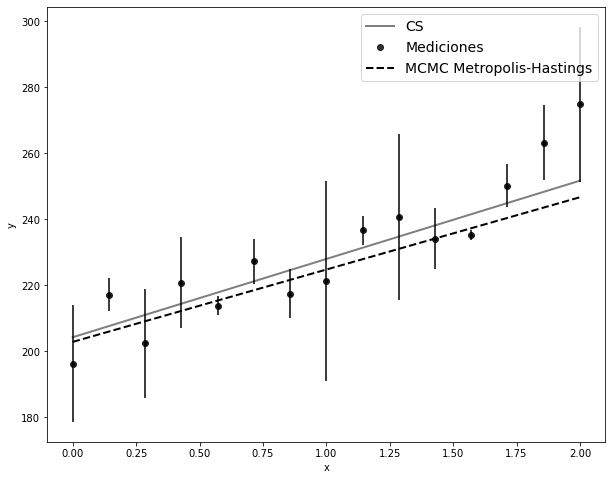

RESULTADOS DE PARÁMETROS
Chi squared:
[204.26655977  23.7363402 ]
MCMC Metropolis Hastings:
[202.86060678  21.9287847 ]


In [346]:
def funccs(x1, A, B):  #Para graficar el ajuste por Chi-squared
    return A+B*x1

popt, pcov = curve_fit(funccs, xd, yd, sigma=np.abs(yderror)**.5) #Ajuste por Chi-squared

plt.figure(figsize=(10,8))
plt.errorbar(xd, yd, yerr=yderror, fmt=".k", capsize=0)
plt.plot(xd,funccs(xd,popt[0],popt[1]),"k", alpha=0.5, lw=2, label="CS")
plt.plot(xd,yd,'ko', alpha=0.8, lw=2, label="Mediciones")

def func(x1, A, B): #Graficando resultados del algoritmo Metropolis-Hastings
    return A+B*x1
fd=len(T_cam[0,:,:])
plt.plot(xd,func(xd,T_cam[0,fd-1,0],T_cam[0,fd-1,1]),"--k", alpha=1, lw=2, label="MCMC Metropolis-Hastings")

plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
print("RESULTADOS DE PARÁMETROS")
print("Chi squared:")
print(popt)
print("MCMC Metropolis Hastings:")
print(T_cam[0,fd-1,:]) 

# Triangle plots

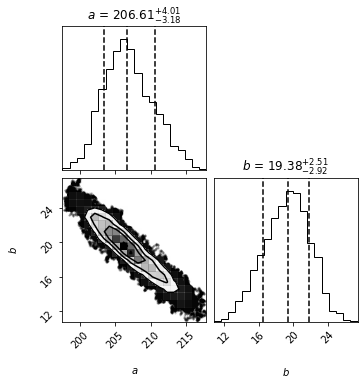

In [343]:
import corner
figure= corner.corner(T_cam[2,200000:,:],labels=[r"$a$", r"$b$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}); 
#Se han descartado los primeros 40000 elementos concluido de la trazas de parámetros

# Librería emcee
### Ahora se hace uso de la librería emcee para analizar los datos.

In [278]:
import emcee #se importa la librería

In [279]:
def log_prior(theta):  #se define una función para el prior y se toma un prior plano.
    b, a, = theta
    return 1

In [280]:
def log_likelihood(theta, xd, yd, yderror): #se define una función para el likehood.
    b, a = theta #parámetros
    model = b * xd + a #modelo
    LL=0
    LL += -0.5*np.sum(np.log(2*np.pi*yderror**2)+(yd - model)**2/(yderror**2))
    return LL

In [281]:
def log_probability(theta, xd, yd, yderror): #se calcula la suma de las probabilidades.
    lp = 0
    return lp + log_likelihood(theta, xd, yd, yderror)

In [294]:
nwalkers=100 #número de walkers
ndim=2 #número de dimensiones (parámetros)
pos=random.uniform(-10,10, size=(nwalkers, ndim)) #generador de valores guess
#***Usando emcee***
n_iterations=1000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xd, yd, yderror))
sampler.run_mcmc(pos,n_iterations, progress=True);

100%|█████████████████████████████████████| 1000/1000 [00:05<00:00, 168.88it/s]


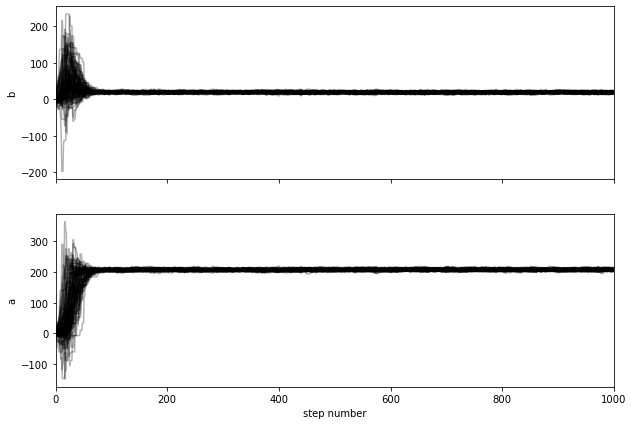

In [295]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b", "a"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [296]:
import corner

In [335]:
flat_samples = sampler.get_chain(discard=100,thin=10, flat=True) #Descartando los primeros 100 elementos
#print(flat_samples.shape)

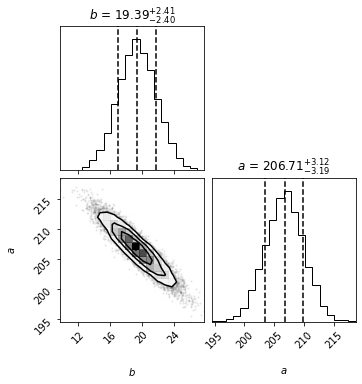

In [344]:
#fig = corner.corner(flat_samples, labels=labels);
figure = corner.corner(flat_samples, labels=[r"$b$", r"$a$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

 Incertidumbres basadas en el décimo sexto, quincuagésimo y octogésimo cuarto percentíles de las muestras.

In [345]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>